In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps
import pandas as pd
import scipy as sp

In [2]:
WS = pd.read_excel('./Dados_C100_patricio.xlsx')
df_c100 = ps.DataFrame(WS)

WS = pd.read_excel('./Tensão_vs_SoC_C100.xlsx')
df_soc = ps.DataFrame(WS)

In [7]:
points = [
36,
17299,
34586,
51912,
69298,
86728,
104172,
121666,
139361,
157114,
36,
21738,
39026,
56352,
73738,
91168,
108612,
126106,
143801,
161554,
]

In [8]:
def modelo_2rc(t, v0, v1, v2, t1, t2):
    return v0+v1*np.exp(-t*t1)+v2*np.exp(-t*t2)

In [9]:
def get_t_v(p1, df):
    p1, p2 = p1, p1+200
    corrente = df['Corrente [A]'][p1-1]
    v_zp1 = df['Tensão [V]'][p1-1]

    df_teste = df[p1:p2][['Tempo [s]', 'Tensão [V]']].clone()
    df_teste = df_teste.select([ps.col('Tempo [s]').alias('t'), ps.col('Tensão [V]').alias('v')])

    vmin = df_teste['v'].min()
    vmax = df_teste['v'].max()

    df_teste['t'] = df_teste['t']-df_teste['t'][0]
    df_teste['v'] = df_teste['v']-df_teste['v'][0]

    t = df_teste['t'].to_numpy()
    v = df_teste['v'].to_numpy()
    return t, v, corrente, vmin, vmax, v_zp1

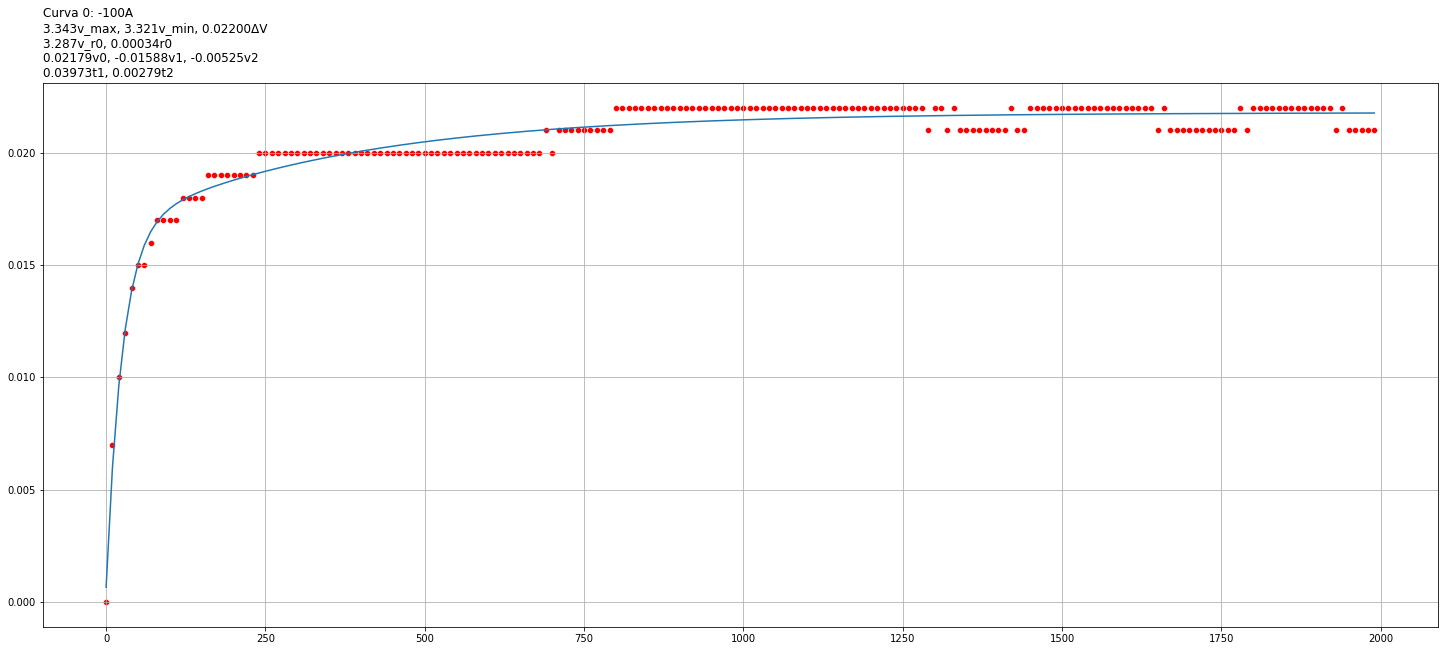

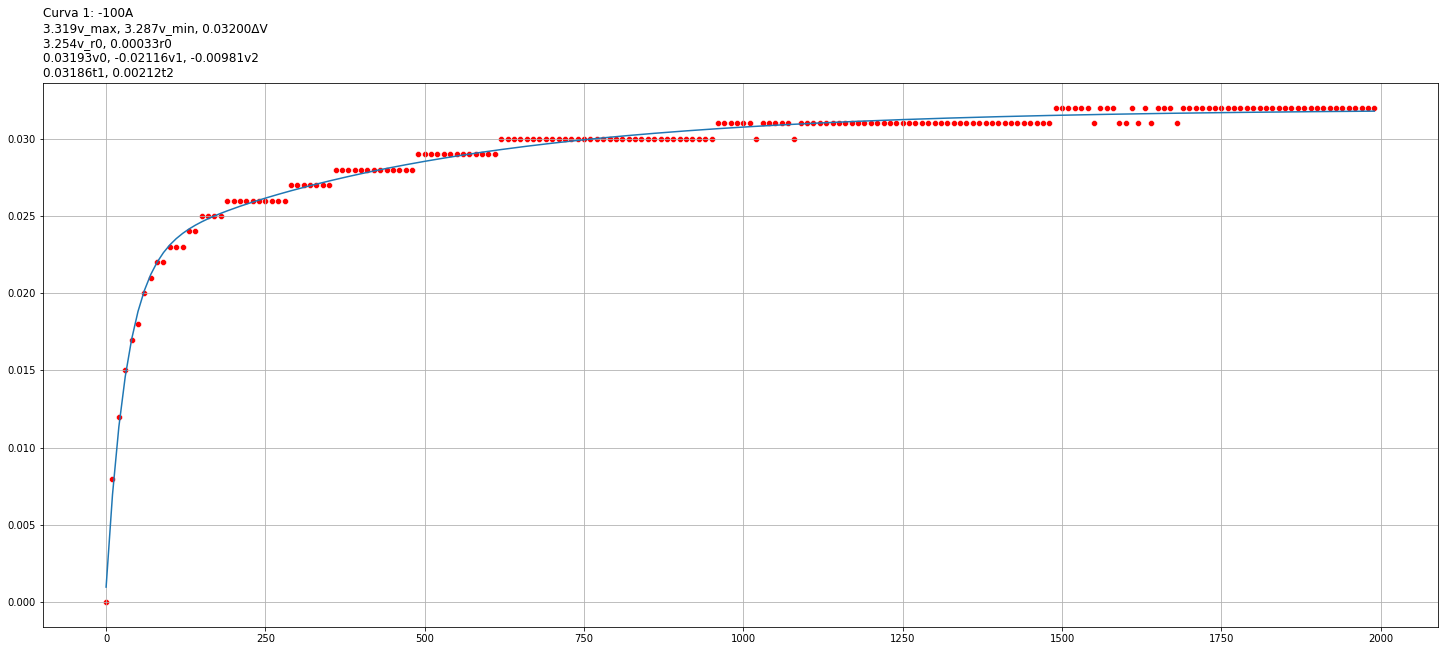

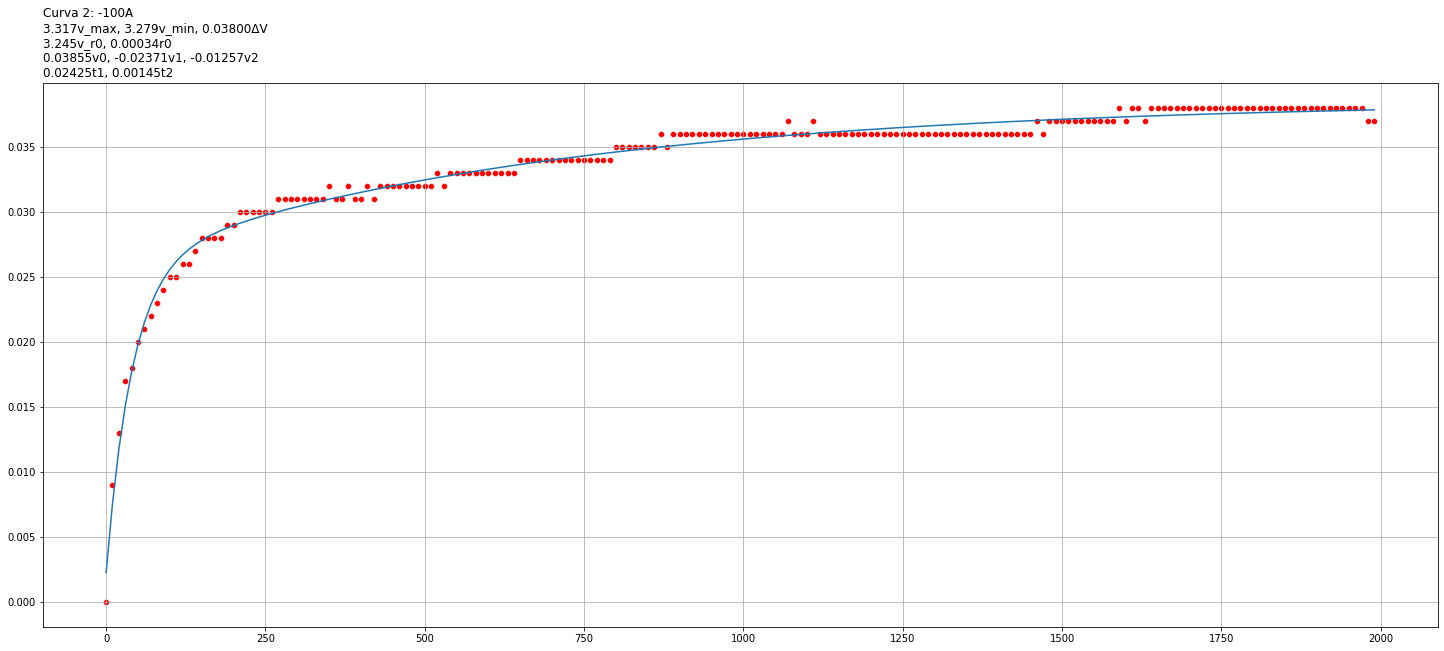

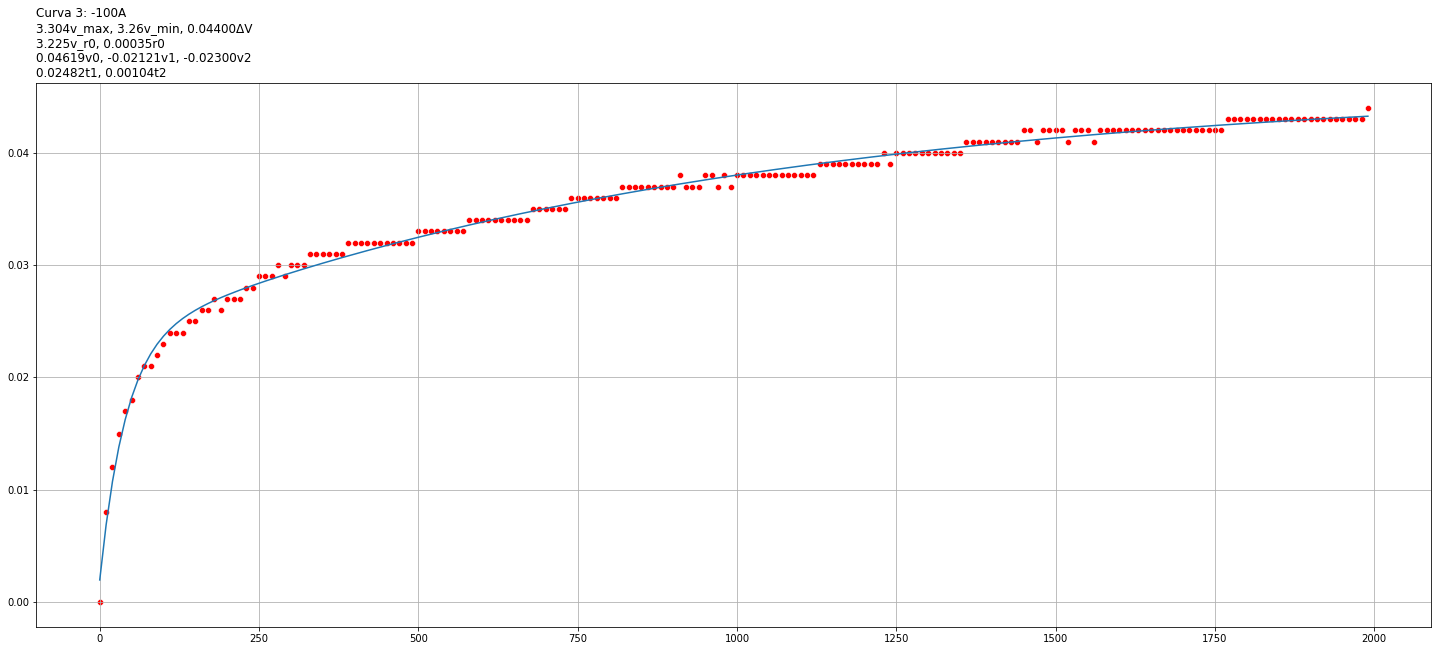

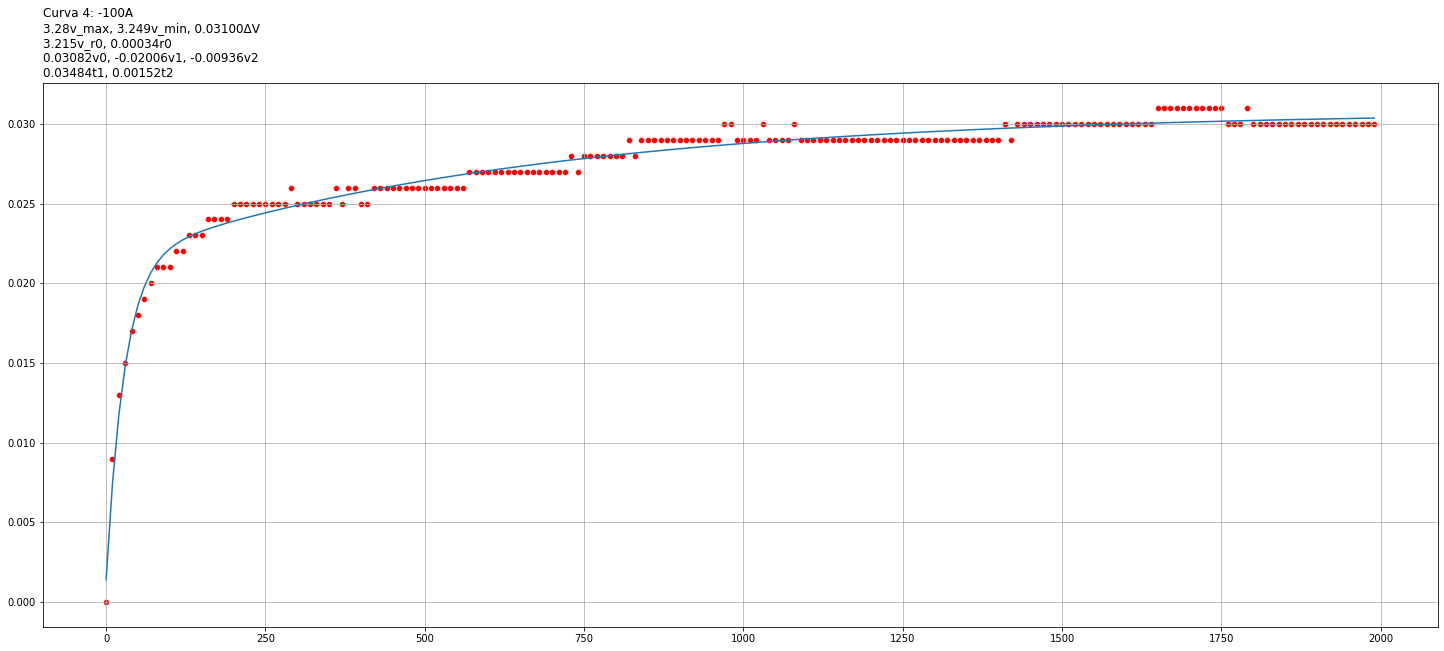

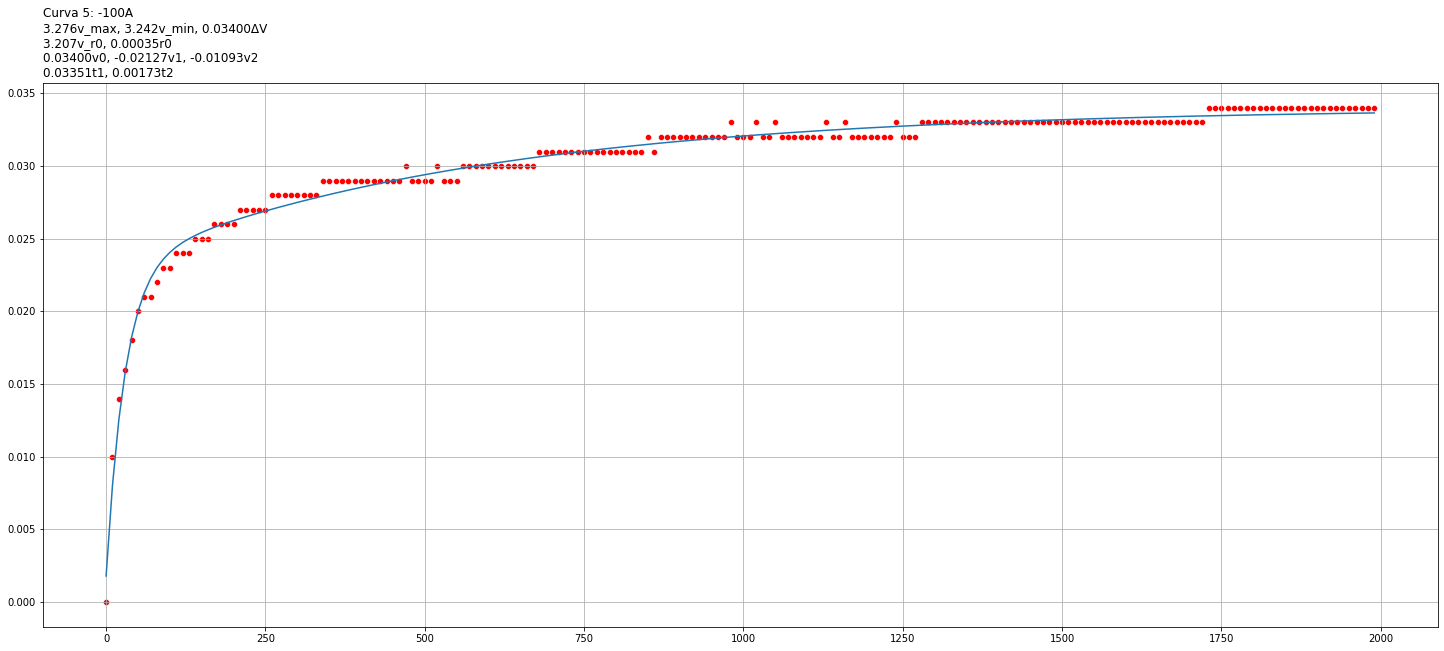

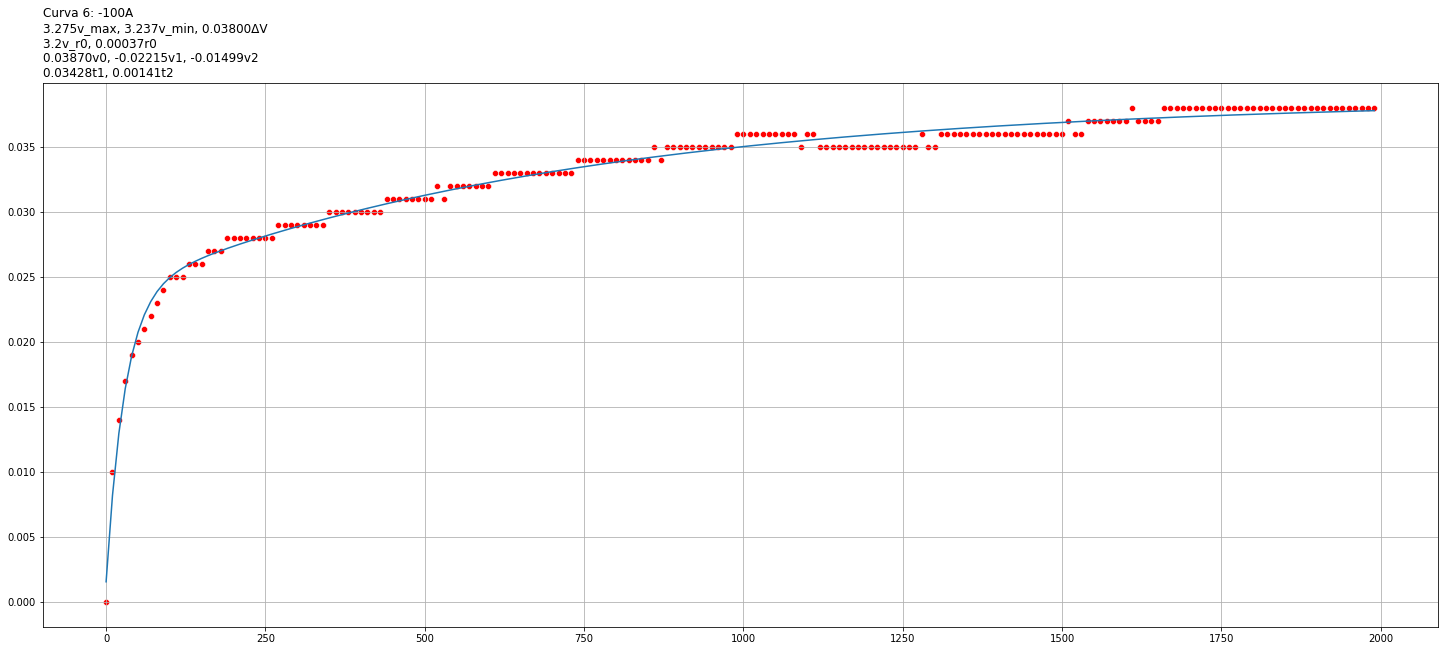

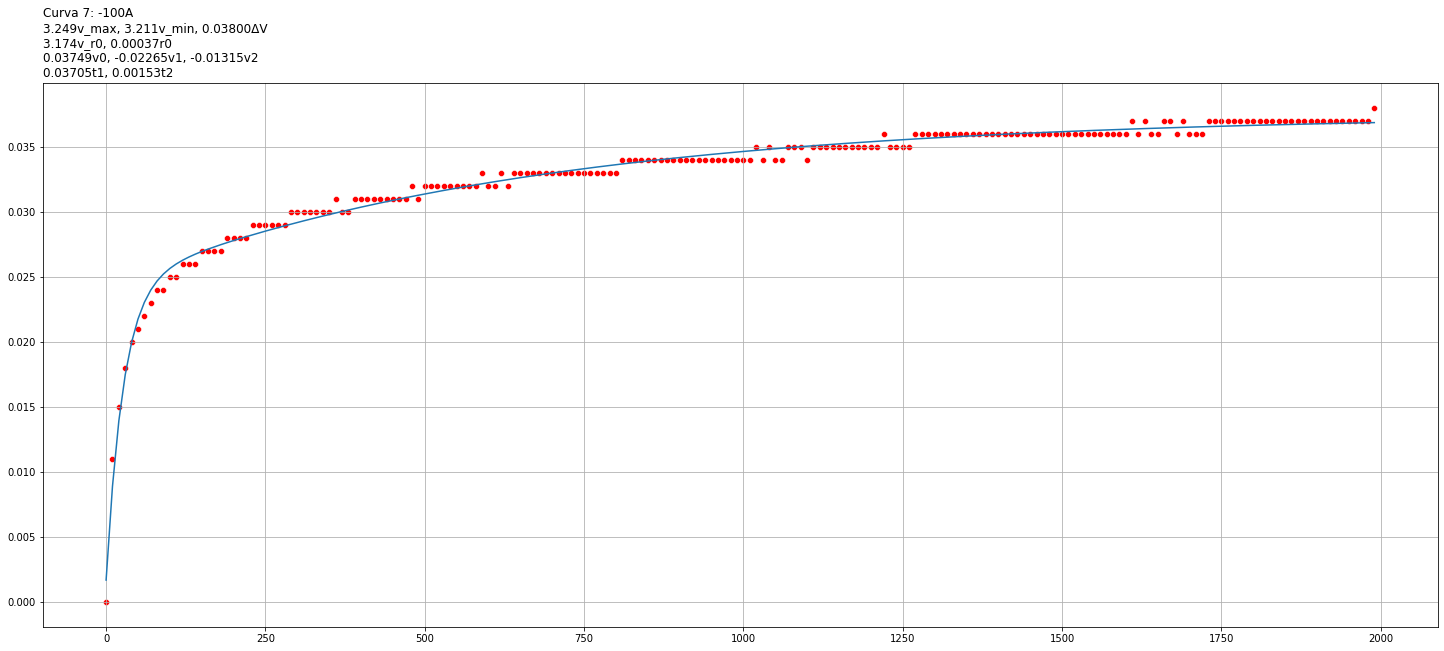

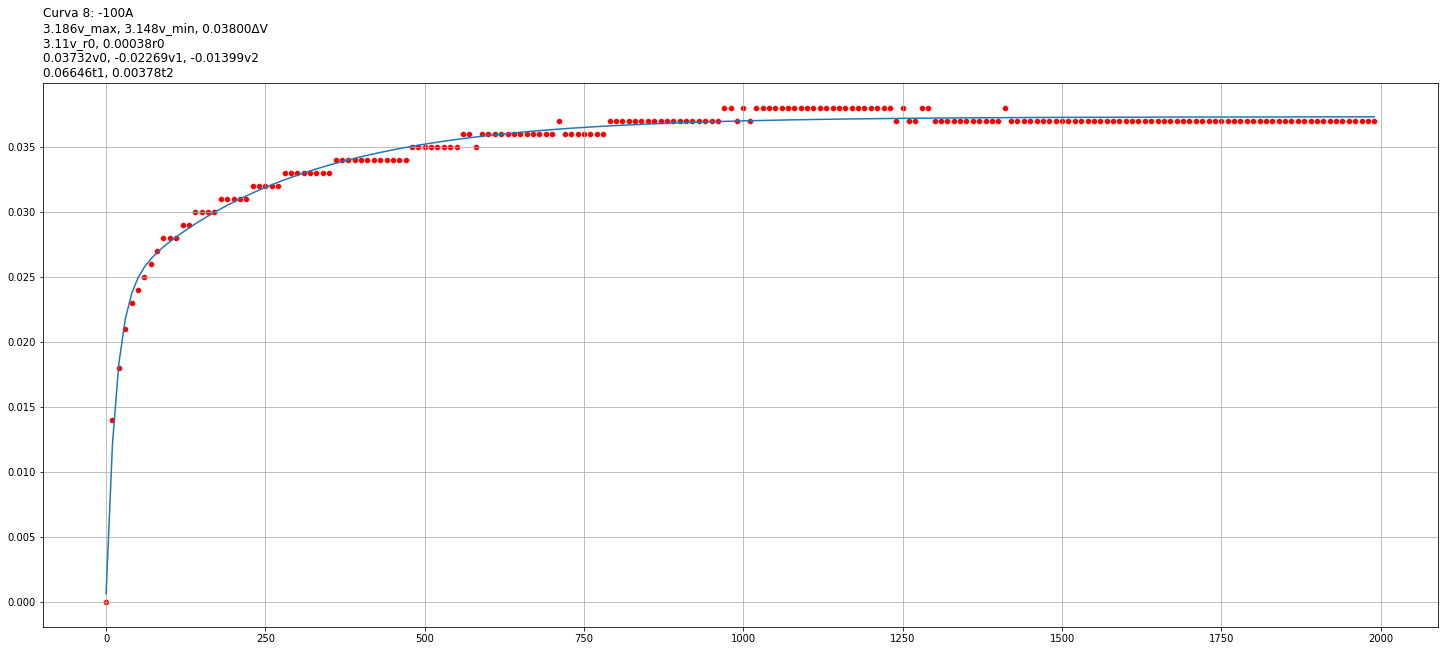

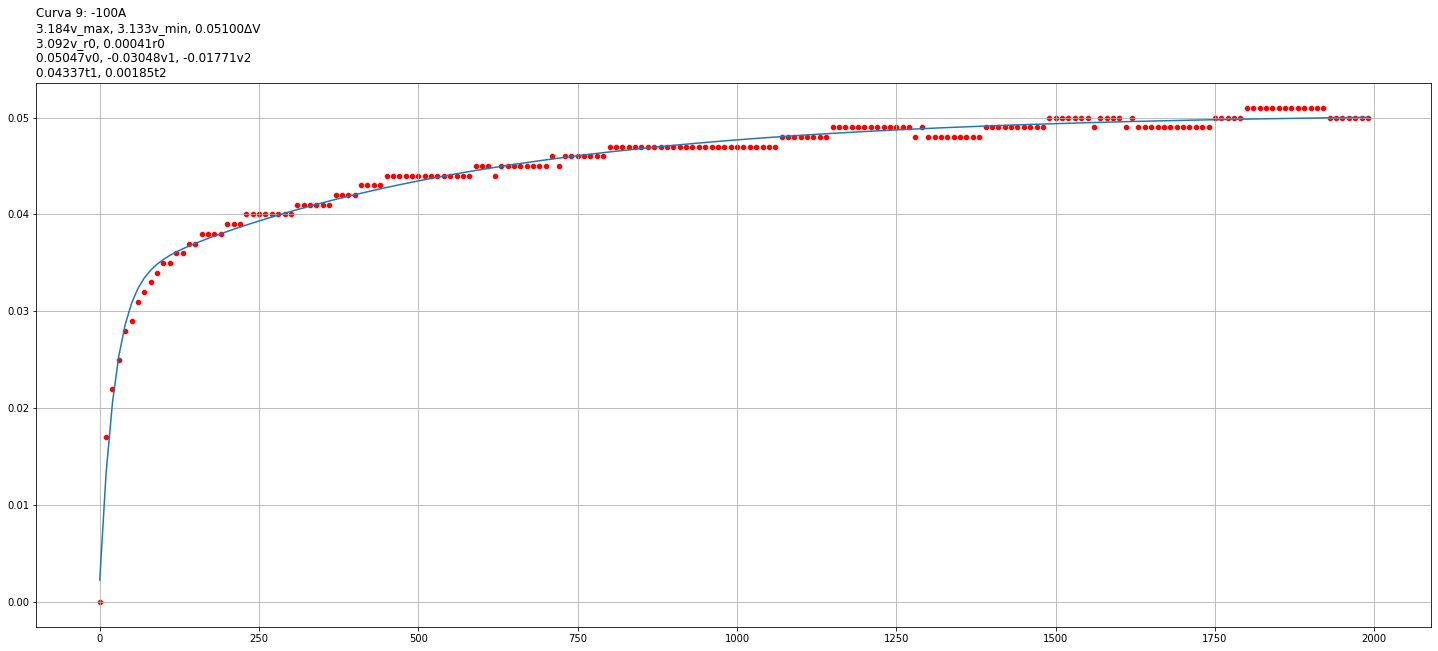

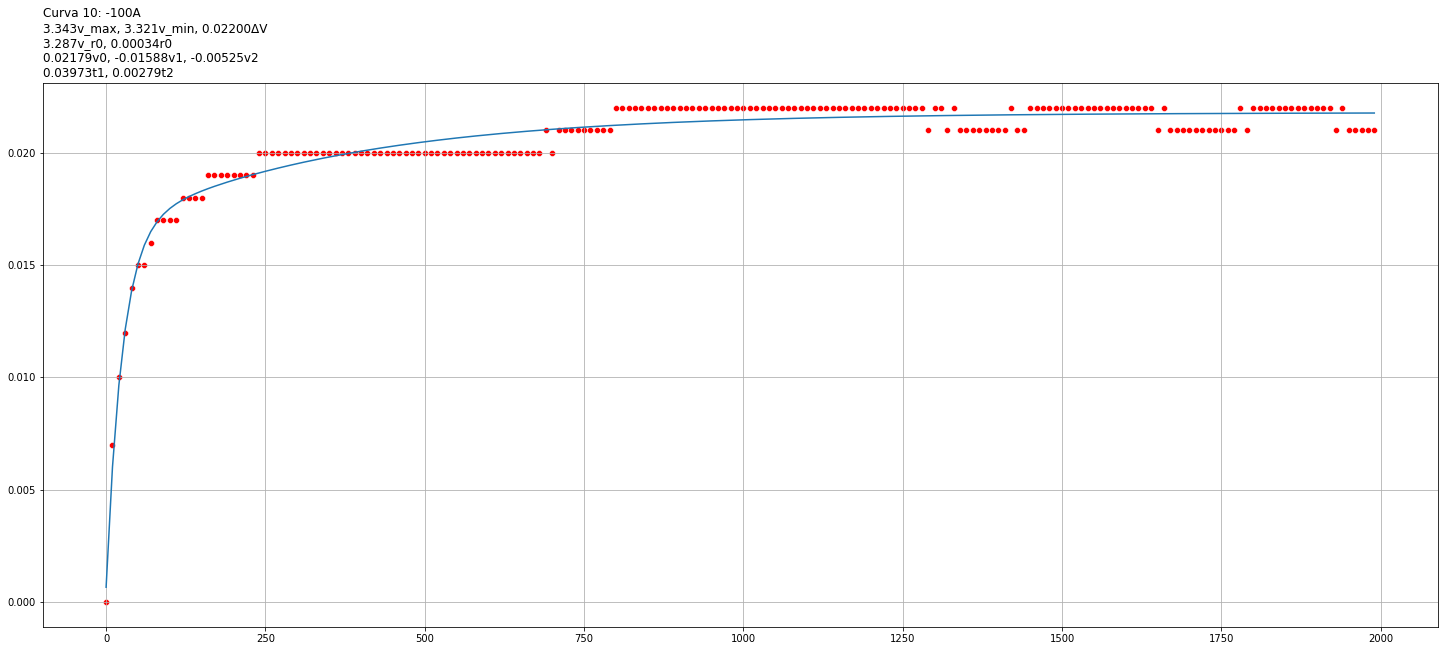

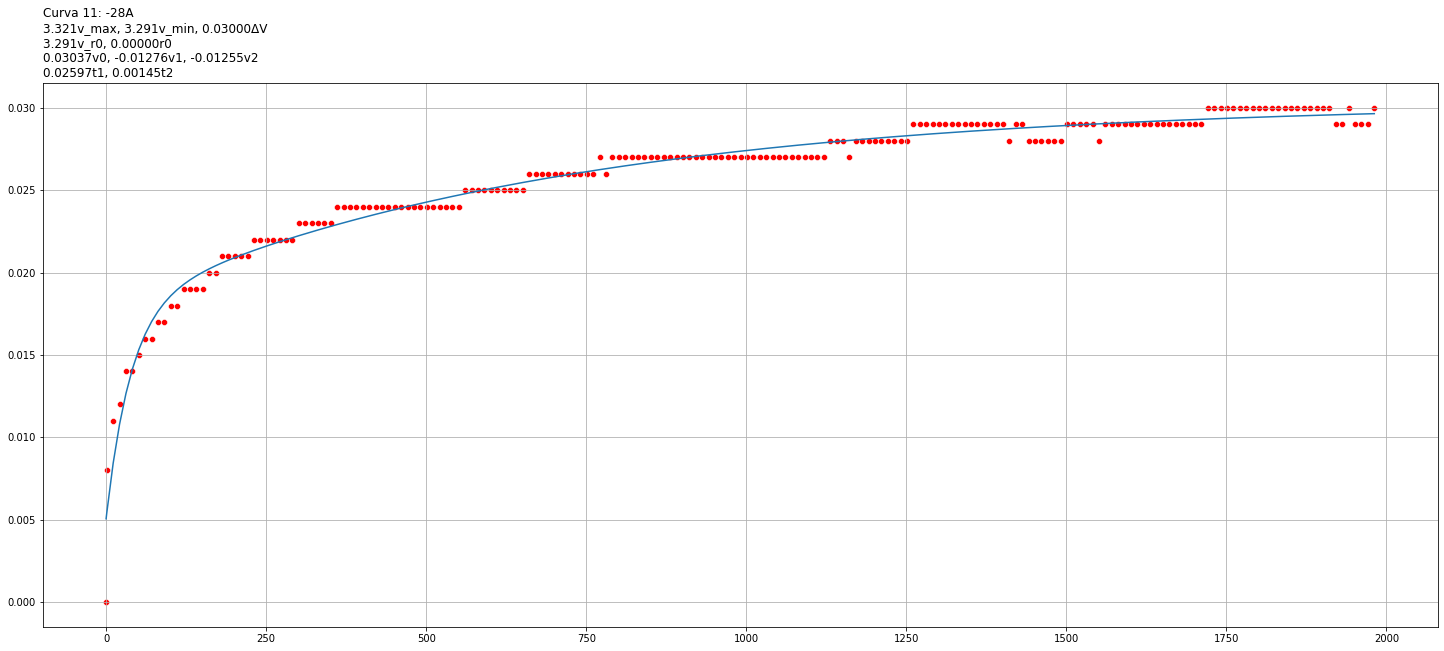

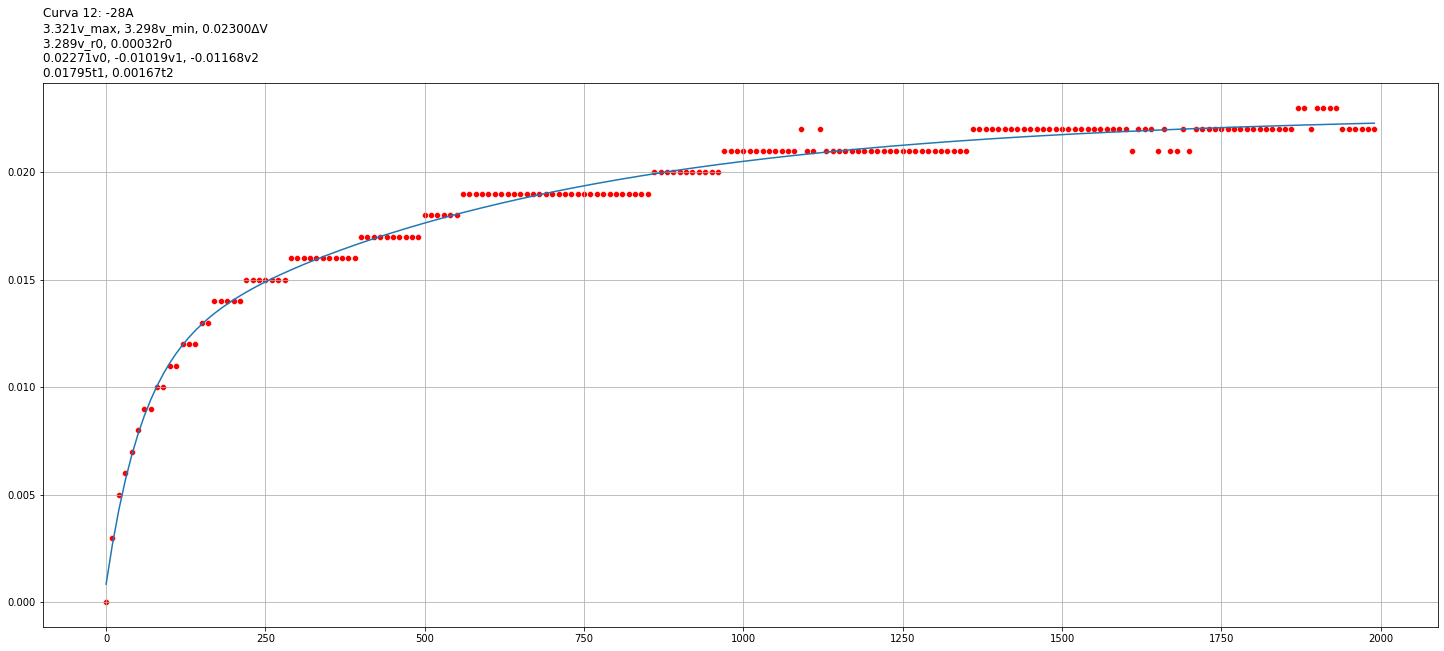

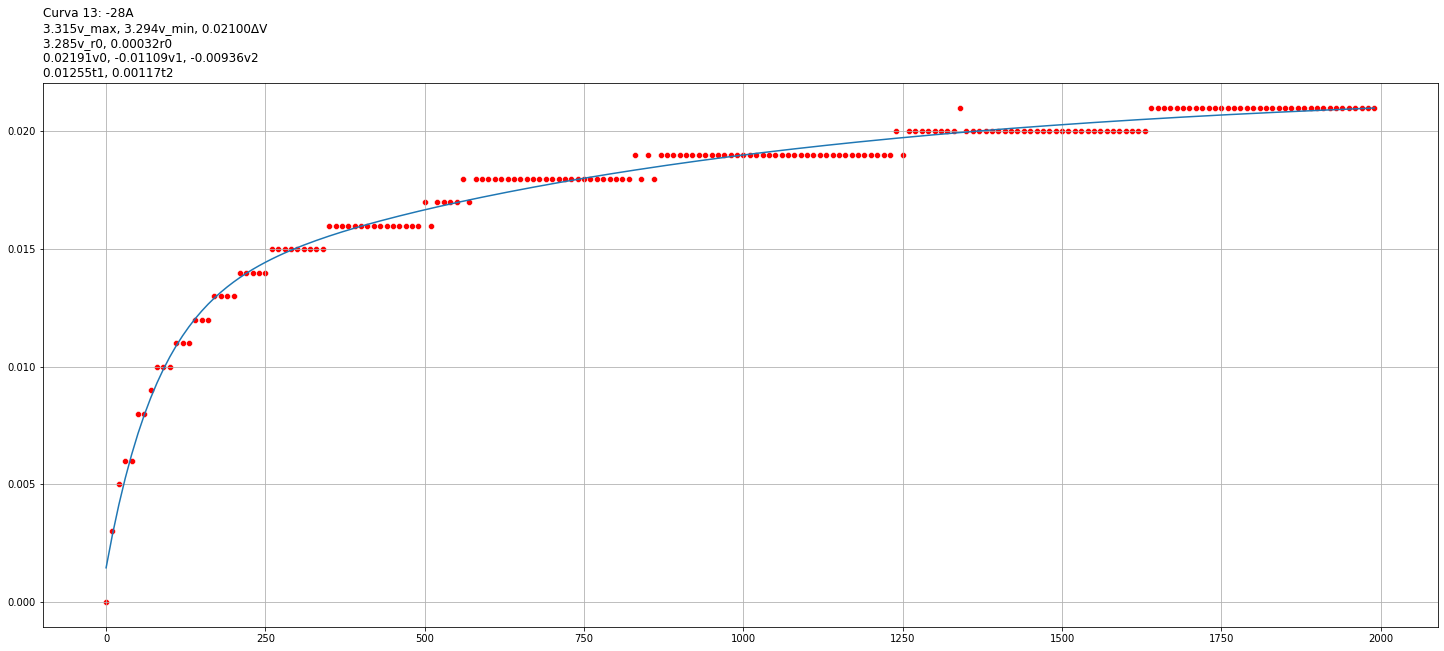

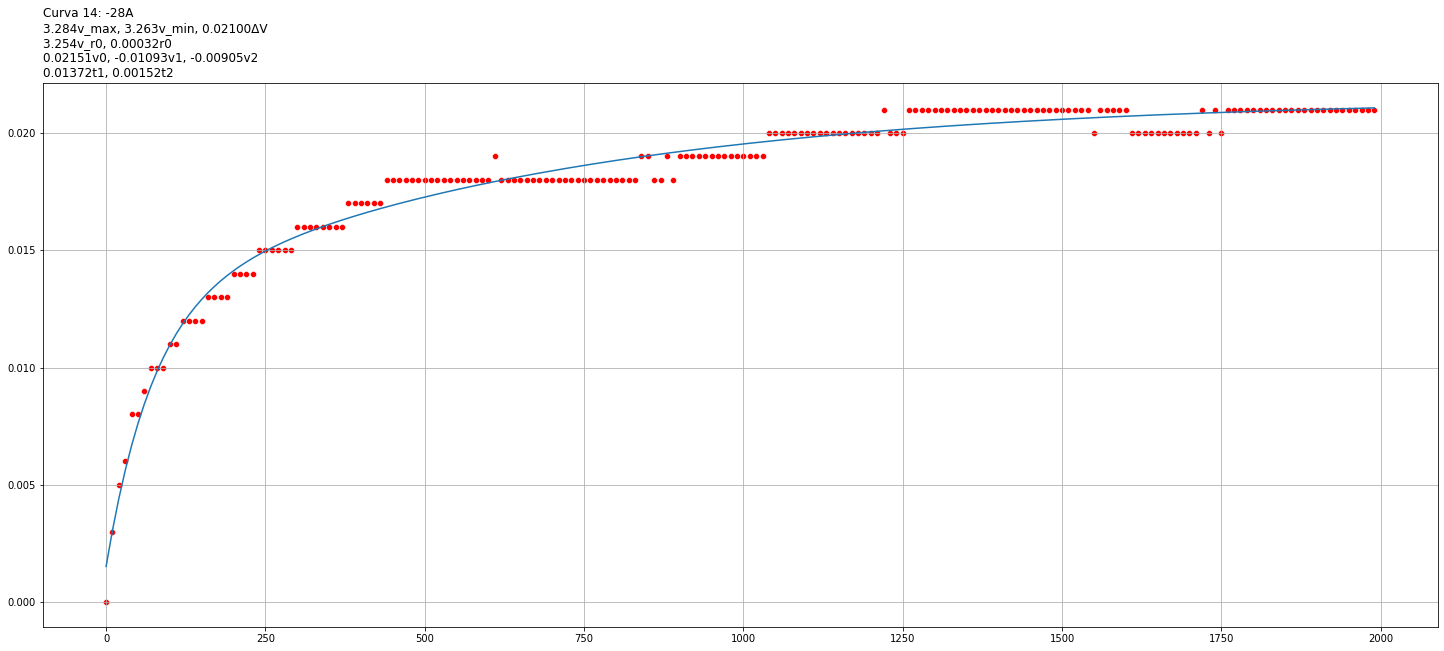

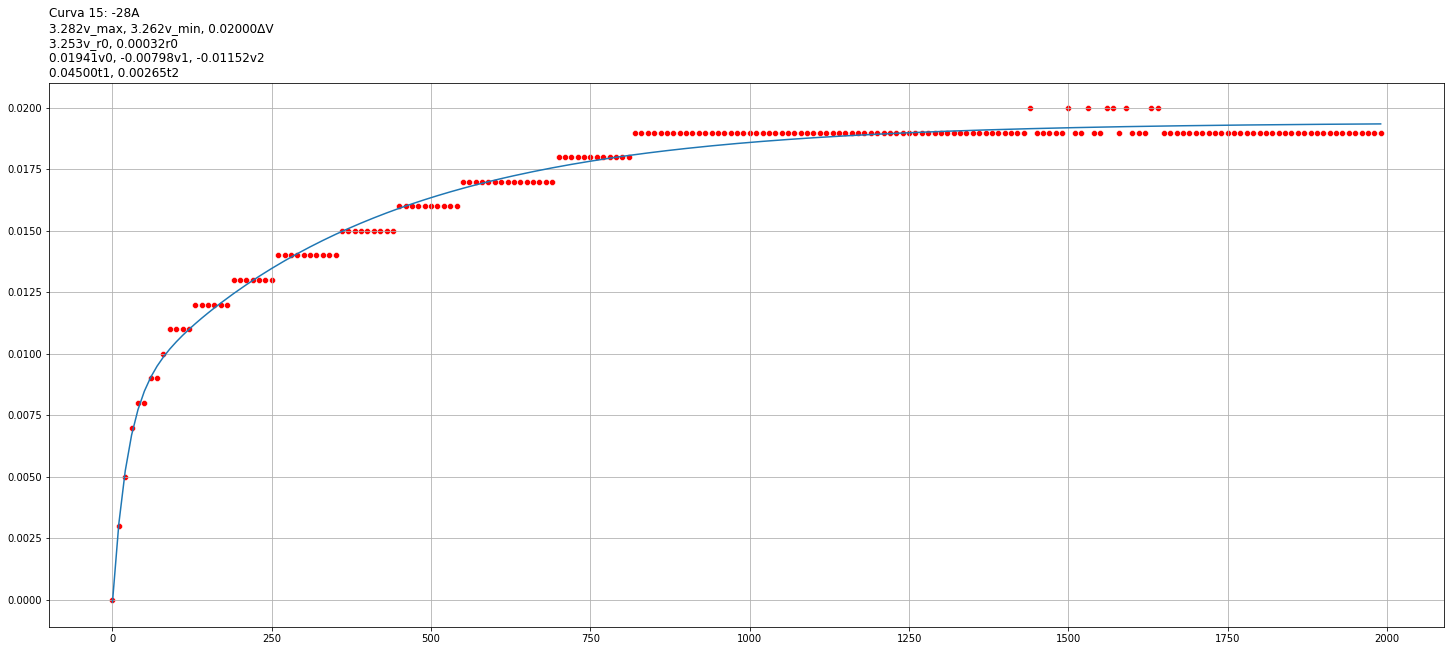

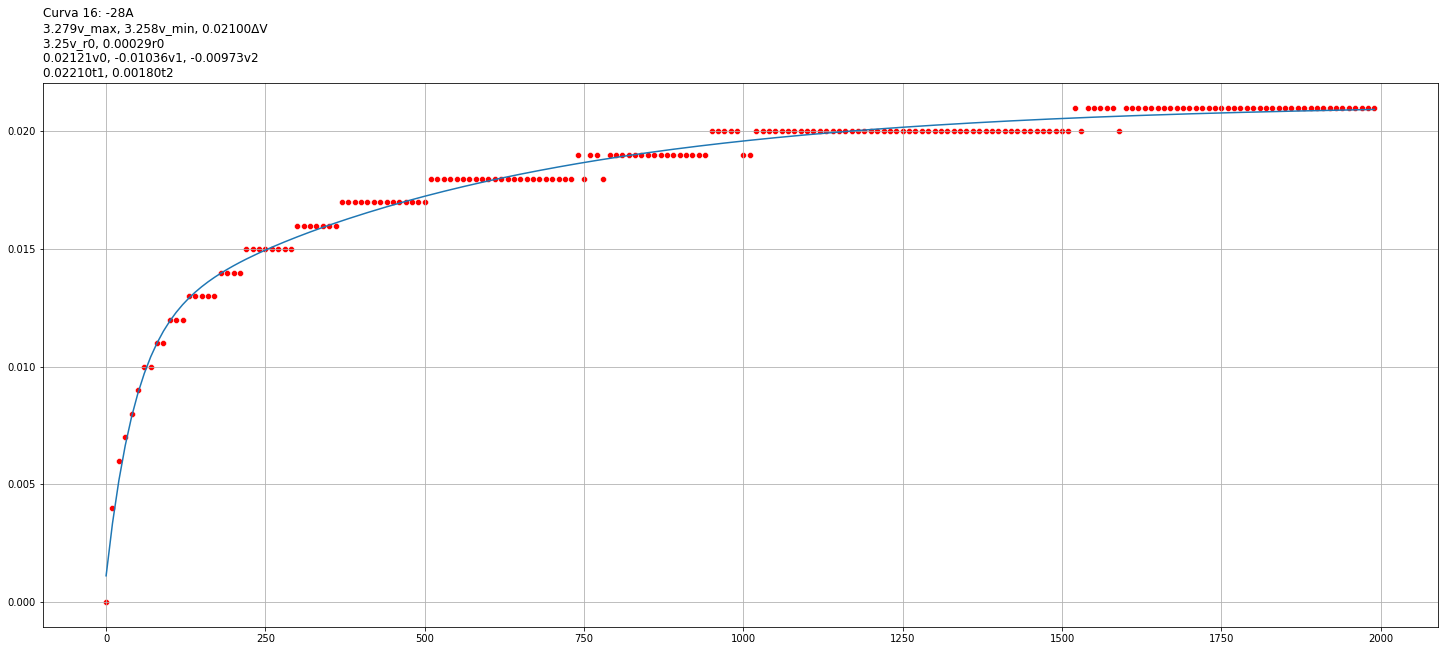

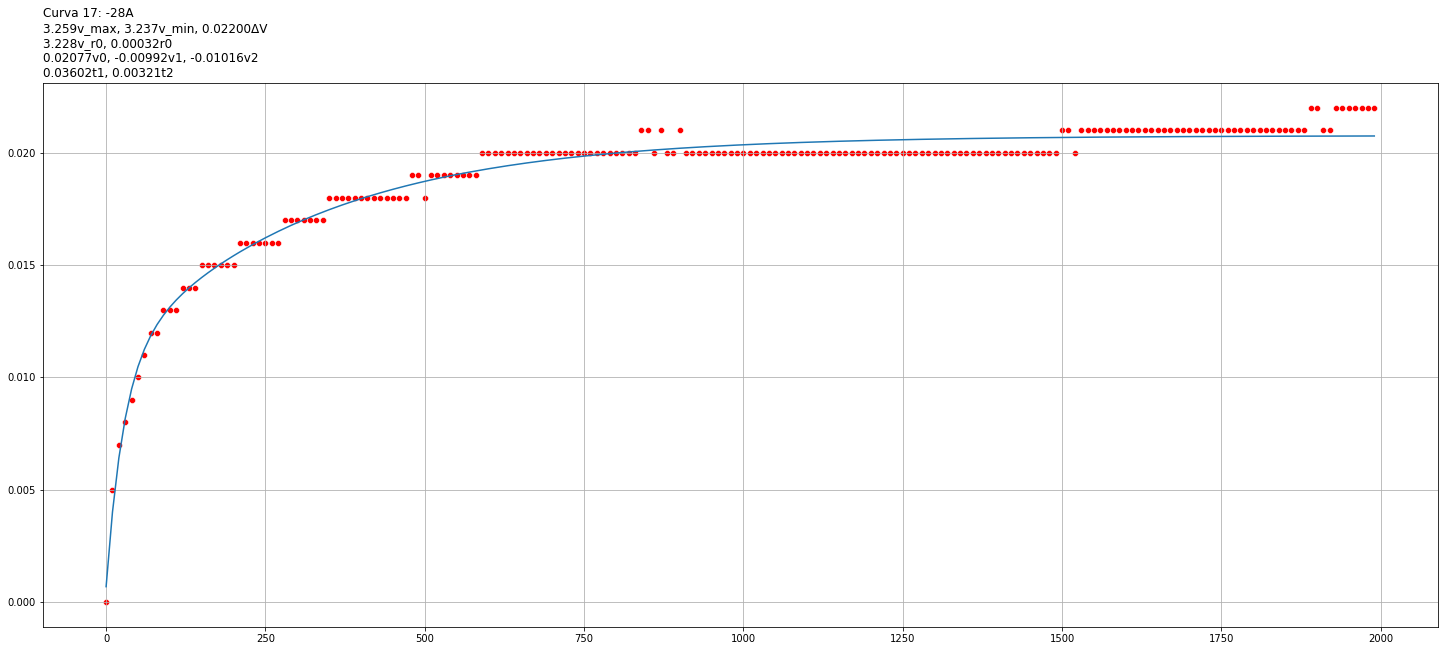

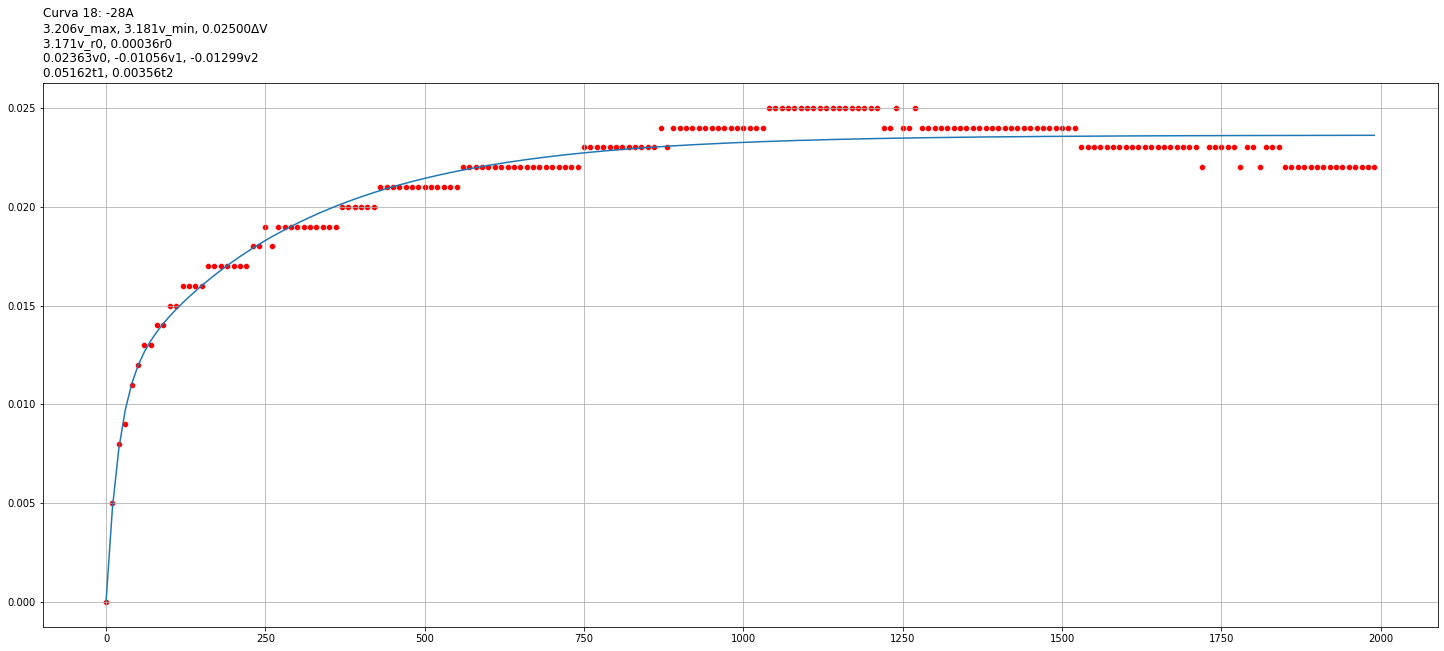

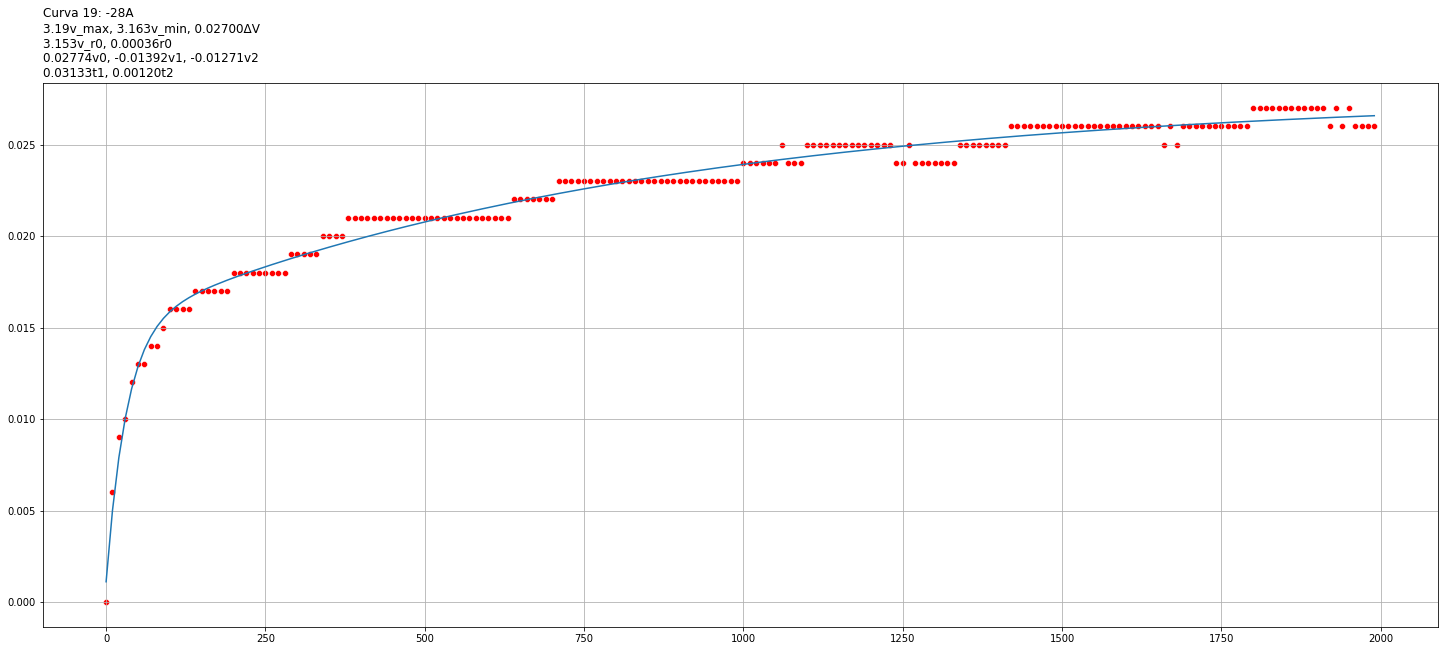

In [10]:
p0 = np.array([ 3.31893375e+00, -2.11580237e-02, -9.80514235e-03,  3.18578442e-02, 2.12246228e-03])+np.random.normal(0, 0.001, 5)

for i, p1 in enumerate(points):
    t, v, corrente, vmin, vmax, v_r0 = get_t_v(p1, df_c100)
    sigma = np.array([0]*t.size)
    vals, cov = sp.optimize.curve_fit(f=modelo_2rc, xdata=t, ydata=v, p0=p0)
    p0 = vals+np.random.normal(0, 0.001, 5)

    plt.figure(figsize=(25, 10))
    plt.title(
f'''Curva {i}: {corrente:.0f}A
{vmax}v_max, {vmin}v_min, {vmax-vmin:.5f}ΔV
{v_r0}v_r0, {-(vmin-v_r0)/corrente:.5f}r0
{vals[0]:.5f}v0, {vals[1]:.5f}v1, {vals[2]:.5f}v2
{vals[3]:.5f}t1, {vals[4]:.5f}t2''',
    loc='left')

    sns.scatterplot(y=v, x=t, color='red')
    sns.lineplot(y=modelo_2rc(t, *vals), x=t)
    plt.grid()
    plt.show()
    plt.close()